# Tutorial 2: Simulating survey datasets
In this tutorial, we will review how to use the Survey class to simulate an exoplanet survey, as well as how to configure the Survey's parameters.

## Setup

Let's start by importing the necessary module from Bioverse.

In [1]:
# Import the Generator, ImagingSurvey, and TransitSurvey classes
from bioverse.generator import Generator
from bioverse.survey import ImagingSurvey, TransitSurvey

# Import pyplot (for making plots later) and adjust some of its settings
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 20.

## Loading the Survey object

Bioverse uses ImagingSurvey and TransitSurvey objects to simulate datasets from a direct imaging or transit spectroscopy exoplanet survey. Each has a 'default' option. Let's take a look at the default imaging survey:

In [2]:
# Load the 'defalt' imaging survey
survey = ImagingSurvey('default')

# Display some key properties
print("Telescope diameter: {:.1f} meters".format(survey.diameter))
print("Inner working angle: {:.1f} lambda/D".format(survey.inner_working_angle))
print("Outer working angle: {:.1f} lambda/D".format(survey.outer_working_angle))
print("Faintest detectable contrast: {:.1E}".format(10**survey.contrast_limit))

Telescope diameter: 15.0 meters
Inner working angle: 3.5 lambda/D
Outer working angle: 64.0 lambda/D
Faintest detectable contrast: 2.5E-11


Next, the default transit survey:

In [3]:
# Load the transit survey
survey = TransitSurvey('default')

# Display some key properties
print("Effective telescope diameter: {:.1f} meters".format(survey.diameter))
print("Typical target star temperature: {:.0f} K".format(survey.T_st_ref))
print("Maximum survey lifetime: {:.1f} years".format(survey.t_max/365.25))

Effective telescope diameter: 50.0 meters
Typical target star temperature: 3300 K
Maximum survey lifetime: 10.0 years


Each survey is capable of conducting a set of measurements on the planets it observes. Let's take a look at the transit survey:

In [4]:
print(survey)

TransitSurvey with the following parameters:
  label: default
  diameter: 50.0
  t_max: 3652.5
  t_slew: 0.0208
  T_st_ref: 3300
  R_st_ref: 0.315
  D_ref: 50.0
  d_ref: 50.0
  N_obs_max: 1000
  mode: transit

Conducts the following measurements
(0) Measures parameter 'L_st'
(1) Measures parameter 'R_st' with 5% precision
(2) Measures parameter 'M_st' with 5% precision
(3) Measures parameter 'T_eff_st' with 25.0 precision
(4) Measures parameter 'd'
(5) Measures parameter 'H'
(6) Measures parameter 'age' with 30% precision
(7) Measures parameter 'depth'
(8) Measures parameter 'T_dur'
(9) Measures parameter 'P' with 0.001 precision
(10) Measures parameter 'has_H2O'
    Conditions: R>0.7 AND R<1.5 AND a_eff>0.1 AND a_eff<10.0
    Average time required: 7.5 d
(11) Measures parameter 'EEC'
(12) Measures parameter 'has_O2'
    Conditions: EEC==1
    Average time required: 3.1 d


Each measurement is conducted in the order it is listed. Some have special properties:

**Uncertainty:** Some values are measured with approximately zero uncertainty (e.g. distance to the star), while others are measured with poorer precision (e.g. +- 30% for the system's age).

**Conditions:** Not every measurement is applied to every planet. For example, only approximately terrestrial-sized planets orbiting between 0.1 to 10 AU (adjusted for stellar luminosity) are probed for the presence of H2O.

**Total allocated time:** Some characterizations require a large amount of time to complete. For example, for the typical EEC target, the suryey requires ~3 days to detect the presence of ozone in the atmosphere. 

## Producing simulated datasets

The first step in a simulated Survey is to determine which simulated planets can actually be detected. Let's start by generating a sample of planets orbiting stars that might be targeted by LUVOIR. Note that the Generator used here does *not* draw stars from a stellar mass function; instead, it inherits the sophisticated coronagraph yield modeling performed by Stark et al. (2019).

In [5]:
# Generate a sample of planetary systems
generator = Generator('imaging')
sample = generator.generate()

Next, we use the imaging Survey object to determine which of these planets can be detected by LUVOIR.

In [6]:
survey = ImagingSurvey('default')
detected = survey.compute_yield(sample)

print("Detected {:d} planets including {:d} exo-Earth candidates.".format(len(detected), detected['EEC'].sum()))

Detected 349 planets including 15 exo-Earth candidates.


Finally, we simulate a dataset from observations of all of the detected planets over the course of 10 years.

In [7]:
data = survey.observe(detected, t_total=10*365.25)

The values in `data` are imprecise measurements of the true values in `detected`. For example, let's look at the fractional measurement error on the semi-major axis.

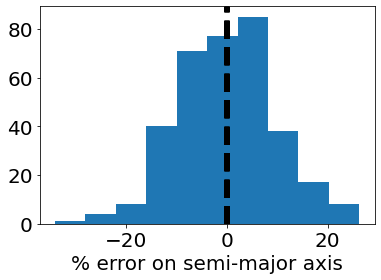

In [8]:
error = (data['a']-detected['a'])/detected['a']
std = np.std(error)

plt.hist(error*100, bins=10)
plt.xlabel('% error on semi-major axis')
plt.axvline(-std, c='black', lw=5, linestyle='dashed')
plt.axvline(std, c='black', lw=5, linestyle='dashed')

The standard deviation, highlighted by black lines, is about 10%. This is the estimated uncertainty in semi-major axis determination following ~3 direct imaging revisits (Guimond & Cowan 2019).

Let's repeat this exercise for the transit survey. This time we will use the stellar mass function to generate host stars, and the `quickrun()` function to consolidate the steps.

In [9]:
# Load the Generator and Survey
generator = Generator('transit')
survey = TransitSurvey('default')

# Instead of this:
# sample = generator.generate(transit_mode=True)
# detected = survey.compute_yield(generator)
# data = survey.observe(sample, t_total=10*365.25)

# Use this:
sample, detected, data = survey.quickrun(generator, t_total=10*365.25) # note that transit_mode = True is automatically passed for transit surveys

Because the transit survey mostly observes low-mass stars, planet ages are difficult to constrain. The state of the art for low-mass stellar age constraints is around 30% (for TRAPPIST-1; see Burgasser & Mamajek 2017)

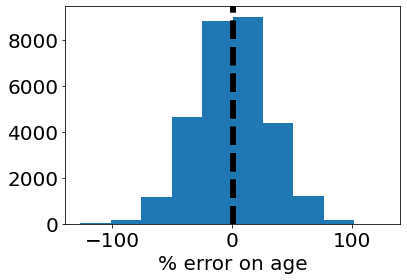

In [10]:
error = (data['age']-detected['age'])/detected['age']
std = np.std(error)

plt.hist(error*100, bins=10)
plt.xlabel('% error on age')
plt.axvline(-std, c='black', lw=5, linestyle='dashed')
plt.axvline(std, c='black', lw=5, linestyle='dashed')

## Time constraints

In principle, the transit survey is capable of detecting and characterizing any transiting planet, provided it can observe enough transits to build up the spectroscopic signal-to-noise ratio. In reality, the total number of transits it can observe is limited by survey duration.

For example, a key observable parameter for terrestrial planets is the presence (or absence) of H2O in the atmosphere. However, water clouds obscure almost all absorption from water vapor along the same sightlines. Using the Planetary Spectrum Generator with sophisticated GCM models that include the effects of clouds, we have estimated that the transit survey will require approximately ~7.5 days of in-transit observing time for a typical star, assuming a 50-meter effective diameter. We incorporate this assumption into the 'has_H2O' measurement:

In [11]:
# Retrieve the time required for the has_H2O measurement
t_ref = survey.measurements['has_H2O'].t_ref

# Properties of the reference star
T_st_ref = survey.T_st_ref
R_st_ref = survey.R_st_ref

print("Reference star properties: R = {:.1f} R_sun and T_eff = {:.0f} K".format(R_st_ref, T_st_ref))
print("Time required to characterize an Earth-like planet around this star: {:.1f} d".format(t_ref))

Reference star properties: R = 0.3 R_sun and T_eff = 3300 K
Time required to characterize an Earth-like planet around this star: 7.5 d


`t_ref` is scaled according to planet size, stellar size, stellar distance, atmospheric scale height, etc. to produce an estimate for the observing time required for each individual planet.

Plotted below are the exposure times (and number of transit observations) required to find H2O in the atmospheres of transiting EECs. The dashed lines indicate a generous upper limit of 1,000 combined transit observations of ~1 hr duration.

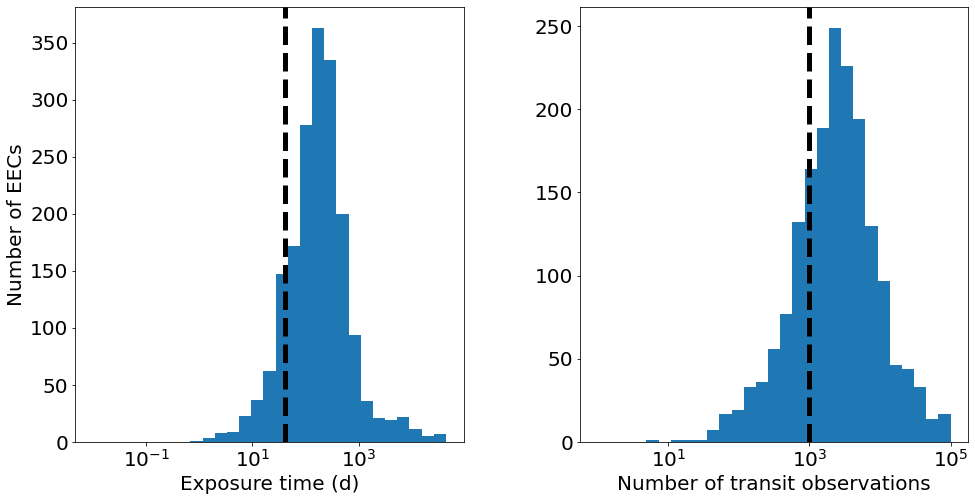

In [12]:
sample, detected, data = survey.quickrun(generator, t_total=10*365.25)
t_exp, N_obs = survey.measurements['has_H2O'].compute_exposure_time(data[detected['EEC']])

fig, ax = plt.subplots(ncols=2, figsize=(16,8))

bins = np.logspace(np.log10(0.01), np.log10(np.amax(t_exp)), 30)
ax[0].hist(t_exp, bins=bins)
ax[0].set_xscale('log')
ax[0].set_xlabel('Exposure time (d)')
ax[0].set_ylabel('Number of EECs')
ax[0].axvline(1000/24, linestyle='dashed', lw=5, c='black')

bins = np.logspace(0, 5, 30)
ax[1].hist(N_obs, bins=bins)
ax[1].set_xscale('log')
ax[1].set_xlabel('Number of transit observations')
ax[1].axvline(survey.N_obs_max, linestyle='dashed', lw=5, c='black')

plt.subplots_adjust(wspace=0.3)

As a result, most exo-Earth candidates cannot be observed during the survey. Since the required exposure time scales with distance^2, the successfully observed targets tend to be much closer to Earth.

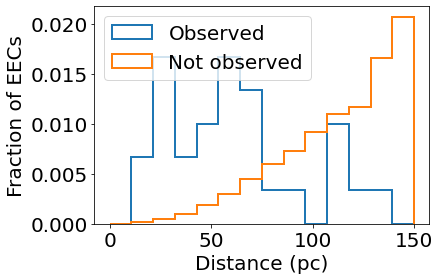

In [13]:
# Determines which EECs were observed vs not observed for atmospheric H2O
obs = ~np.isnan(data['has_H2O'])
EEC = detected['EEC']

bins = np.linspace(0, 150, 15)
plt.hist(data['d'][obs&EEC], density=True, histtype='step', lw=2, bins=bins, label='Observed')
plt.hist(data['d'][~obs&EEC], density=True, histtype='step', lw=2, bins=bins, label='Not observed')
plt.xlabel('Distance (pc)')
plt.ylabel('Fraction of EECs')
plt.legend(loc='upper left')

plt.show()

If we choose more optimistic assumptions about cloud cover, we can reduce `t_ref` and therefore increase the number of observable EECs:

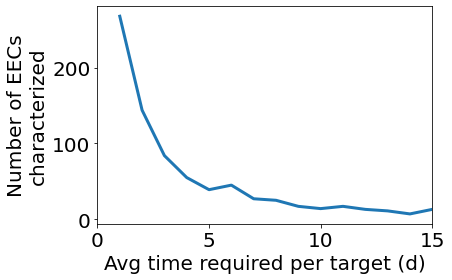

In [14]:
t_ref = np.arange(1, 16)
N_EEC = np.zeros(len(t_ref))
for i, tr in enumerate(t_ref):
    survey.measurements['has_H2O'].t_ref = tr
    sample, detected, data = survey.quickrun(generator, t_total=10*365.25)
    EEC = detected['EEC']
    N_EEC[i] = np.sum(~np.isnan(data['has_H2O'][EEC]))

plt.plot(t_ref, N_EEC, lw=3)
plt.xlim([0, 15])
plt.xlabel('Avg time required per target (d)')
plt.ylabel('Number of EECs\ncharacterized')

plt.show()

Note that these exposure time considerations apply equally to imaging surveys. However, given low values of eta Earth assumed (~7.5%), even a LUVOIR-like survey will likely be volume-limited in the number of EECs it can characterize. For a given observatory configuration, the number of EECs it can spectroscopically characterize is mostly a function of eta Earth. For highly time-intensive observations (e.g. rotational mapping), this may not be the case.